# Risque

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Fonction d'utilité

On utilise la fonction CRRA

$$ u(c) = \frac{c^{1-\sigma}-1}{1-\sigma} $$

In [2]:
def crra(c,sigma):
    if sigma==1.0:
        return np.log(c)
    else :
        return (c**(1-sigma)-1.0)/(1.0-sigma)



## Distribution de risque

On utilise souvent la distribution normale, la gamma pour les distributions avec support positif et bien sur la distribution uniforme. 

In [3]:
from scipy.stats import gamma, norm, uniform

La gamma est très utile pour les distributions positives tronquées: 

In [4]:
F = gamma(0.5,loc=5e2,scale=1e3)

In [5]:
L = F.rvs(1000)

In [6]:
np.mean(L),np.std(L)

(1027.1238031918515, 750.7282959183576)

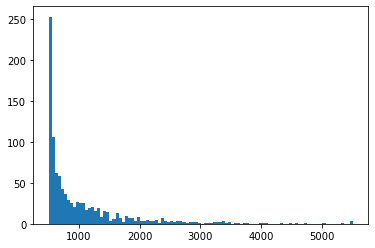

In [7]:
plt.figure()
plt.hist(L,bins=100)
plt.show()

## Utilité espérée évaluée par simulation (avec des tirages)

In [8]:
S = 10000
sig = 1000
sigma = 2.0
eps = norm(0,sig).rvs(S)
wealth = 50e3
eu = np.mean([crra(wealth+e,sigma) for e in eps])
eu

0.9999799913027345

In [9]:
def eucrra(wealth,sigma,eps):
    return np.mean([crra(wealth+e,sigma) for e in eps])

In [10]:
eucrra(wealth,sigma,eps)

0.9999799913027345

## Disposition à payer pour éliminer un risque

On peut trouver la prime de risque $\pi$ tel que : 
$$ u(w-\pi) - Eu(w+\epsilon) = 0$$

On utilise la bisection

In [11]:
def slack(pi,wealth,sigma,eps):
    u = crra(wealth-pi,sigma)
    eu = eucrra(wealth,sigma,eps)
    return eu-u 

On fixe les tirages

In [12]:
from scipy.optimize import bisect
S = 10000
sig = 1000.0
eps = norm(0,1).rvs(S)
wealth = 20e3
bisect(slack, 0.0, 0.95*wealth,args=(wealth,sigma,sig*eps))


46.60157901889761

On le fait pour plusieurs écart-type. Théoriquement, on s'attend à ce que la prime augmente avec l'écart-type

In [13]:
pis = []
sigs = np.linspace(100.0,1000.0,10)
sigma = 2.0
for sig in sigs:
    pis.append(bisect(slack, 0.0, wealth*0.95, args=(wealth,sigma,sig*eps)))
plt.figure()
plt.plot(sigs,pis,label='exact')
plt.xlabel('écart-type du risque')
plt.ylabel('prime de risque')
plt.legend()

ValueError: f(a) and f(b) must have different signs

## Exemple pratique: Disposition à payer pour l'assurance-auto

Supposons une voiture avec une valeur de 50,000\$. L'assureur offre une police avec un déductible de 500\$ et une prime de 275\$. La probabilité d'un accident est de 5/100. S'il y a un accident, le coût des réparations est distribué Gamma avec paramètre 0.5, localisation de 1000\$ et échelle de 1000\$. 
 

Quelle est la perte espérée?

In [14]:

wealth = 50e3
a = 5e3
p = 0.05
S = 10000
F = gamma(0.5,loc=5e3,scale=1e3)
Lc = F.rvs(S)
Lc = np.where(Lc>wealth,wealth*0.99,Lc)
u = uniform(0,1).rvs(S)
eps = np.where(u<p,1.0,0.0)
L = np.multiply(Lc,eps)

In [15]:
np.mean(Lc),np.std(Lc),np.max(Lc)

(5498.101077431216, 696.6913398412117, 13138.351959975105)

In [16]:
np.mean(L),np.std(L),np.max(L)

(279.4440531991446, 1221.0693582018093, 9628.100880272475)

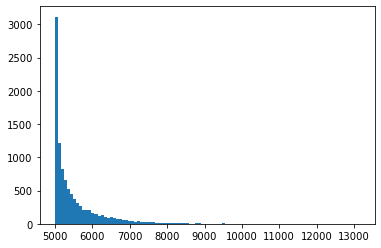

In [17]:
plt.figure()
plt.hist(Lc,bins=100)
plt.show()

Le contrat d'assurance spécifie un déductible de 500 et une prime de 300: 

In [18]:
d = 500.0
prime = 275
I = np.where((L - d)>0,L-d,0.0)
np.mean(I)

254.1440531991446

La prime de l'assureur est plus élevée que la perte moyenne. Donc il fait un profit. 

On calcule la disposition à payer pour cette police (la fonction I)

In [19]:
def slack(wtp,wealth,sigma,L,I):
    eu_n = eucrra(wealth,sigma,-L)
    eu_i = eucrra(wealth-wtp,sigma,-L+I)
    return eu_i-eu_n

In [20]:
sigma = 3.5
bisect(slack, 0.0, 1e3,args=(wealth,sigma,L,I))

312.5

On peut le faire pour des valeurs de l'aversion au risque différentes:

In [21]:
sigmas = np.linspace(1.1,3.5,10)
wtps = []
for sigma in sigmas:
    opt = bisect(slack, 0.0, 5e3,args=(wealth,sigma,L,I))
    wtps.append(opt)

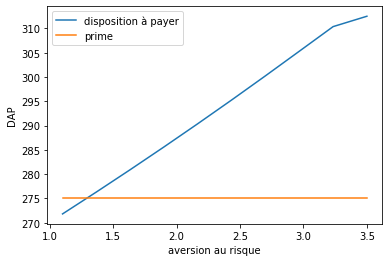

In [22]:
plt.figure()
plt.plot(sigmas,wtps,label='disposition à payer')
plt.plot(sigmas,prime*np.ones(len(sigmas)),label='prime')
plt.xlabel('aversion au risque')
plt.ylabel('DAP')
plt.legend()
plt.show()